#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn
from torch.utils.data.sampler import SubsetRandomSampler

import sys,os
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/"))
from imp import reload 





# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu' # temporarily
# Fix random seeds for reproducibility
seed = 73
#torch.manual_seed(seed)
#np.random.seed(seed)

### Data load

In [2]:
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_for_vib_total.npy")
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_for_vib_total.npy")
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
print(coef.shape, params.shape)

/tmp/ipykernel_252389/491538376.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(2000, 513) (2000, 2)


/tmp/ipykernel_252389/491538376.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


### Normalizations & Dataset for training

In [8]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(np.absolute(coef),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

# Old VIB

### Training VIB

In [15]:
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:307: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 6.4224... Accuracy: 0.0020... Test Om: 0.160 sig: 0.065
Epoch: 200/3000... Loss: 6.4203... Accuracy: 0.0017... Test Om: 0.140 sig: 0.059
Epoch: 300/3000... Loss: 6.4189... Accuracy: 0.0014... Test Om: 0.118 sig: 0.058
Epoch: 400/3000... Loss: 6.4189... Accuracy: 0.0014... Test Om: 0.119 sig: 0.056
Epoch: 500/3000... Loss: 6.4180... Accuracy: 0.0011... Test Om: 0.087 sig: 0.052
Epoch: 600/3000... Loss: 6.4181... Accuracy: 0.0012... Test Om: 0.083 sig: 0.053
Epoch: 700/3000... Loss: 6.4178... Accuracy: 0.0010... Test Om: 0.089 sig: 0.050
Epoch: 800/3000... Loss: 6.4172... Accuracy: 0.0009... Test Om: 0.083 sig: 0.047
Epoch: 900/3000... Loss: 6.4171... Accuracy: 0.0009... Test Om: 0.075 sig: 0.046
Epoch: 1000/3000... Loss: 6.4169... Accuracy: 0.0009... Test Om: 0.082 sig: 0.044
Epoch: 1100/3000... Loss: 6.4169... Accuracy: 0.0009... Test Om: 0.071 sig: 0.046
Epoch: 1200/3000... Loss: 6.4167... Accuracy: 0.0009... Test Om: 0.075 sig: 0.044
Epoch: 1300/3000... Loss:

tensor(0.0724) 0.9493196037660103
tensor(0.0395) 0.8722565470309379


/tmp/ipykernel_31465/2405665974.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))


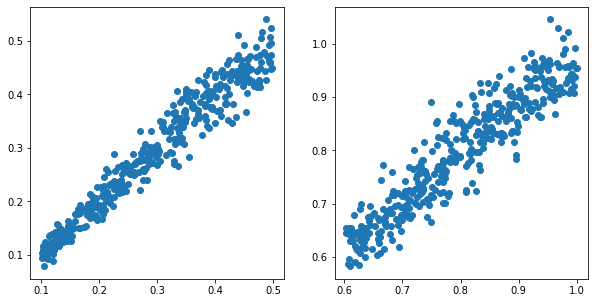

In [41]:
vib.eval()
X_, y_ =test_dataset.tensors
y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel1 = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
rel2 = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y[:,1],y_pred[:,1]))
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])

### Bias Test

In [ ]:
vib.eval()
val_indices = np.array(val_indices)
x_tng, y_tng = X[val_indices[val_indices<1000]], y[val_indices[val_indices<1000]]
x_sim, y_sim = X[val_indices[val_indices>1000]], y[val_indices[val_indices>1000]]

y_tng_pred, _, _ = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()


rel1 = (y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = (y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = np.abs(y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_tng[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_tng[:,1],y_tng_pred[:,1]))



fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1])
plt.plot(ideal2,ideal2,"r")





y_sim_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_sim_pred = y_sim_pred.cpu().detach().numpy()


rel1 = (y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_sim_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_sim_pred[:,1]))

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_sim_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_sim_pred[:,1])
plt.plot(ideal2,ideal2,"r")

## Captum

In [4]:
import captum
reload(captum)
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [17]:
ig = captum.attr.IntegratedGradients(vib.cuda())

In [18]:
test_input_tensor = X[val_indices].cuda()
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

Average Feature Importances


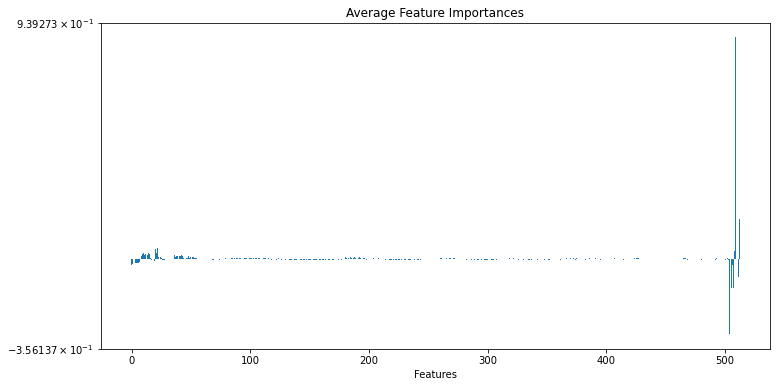

In [19]:
# Helper method to print importances and visualize distribution
def visualize_importances(importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    #for i in range(len(feature_names)):
    #    print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(importances)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        #plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(np.mean(attr, axis=0))
plt.yscale("symlog")

# New VIB

## Class dataset

In [2]:
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_for_vib_total_.npy")
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_for_vib_total_.npy")
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
print(coef.shape, params.shape)

/tmp/ipykernel_544518/491538376.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(2000, 3105) (2000, 2)


/tmp/ipykernel_544518/491538376.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


In [3]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y_params   = torch.tensor(params,dtype=torch.float)
y    = torch.zeros((y_params.shape[0],y_params.shape[1]+2))
y[:,:2] = y_params
y[:1000,2] = 1.
y[1000:,3] = 1.
X = torch.tensor(np.absolute(coef),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices,:2])

### Training VIB

### L=10

In [4]:
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib1 = NDR(input_shape, output_shape,z_dim, num_models=2)
total_loss, accuracy = train_ndr(vib1, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:655: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, y_sigma = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: -3.0961... Accuracy: 0.0025... Test Om: 0.268 sig: 0.079
Epoch: 200/3000... Loss: -10.0053... Accuracy: 0.0013... Test Om: 0.091 sig: 0.063
Epoch: 300/3000... Loss: -16.0350... Accuracy: 0.0010... Test Om: 0.081 sig: 0.054
Epoch: 400/3000... Loss: -20.9843... Accuracy: 0.0010... Test Om: 0.075 sig: 0.060
Epoch: 500/3000... Loss: -24.9047... Accuracy: 0.0009... Test Om: 0.070 sig: 0.056
Epoch: 600/3000... Loss: -27.9631... Accuracy: 0.0008... Test Om: 0.069 sig: 0.046
Epoch: 700/3000... Loss: -30.2884... Accuracy: 0.0008... Test Om: 0.060 sig: 0.043
Epoch: 800/3000... Loss: -32.0378... Accuracy: 0.0007... Test Om: 0.057 sig: 0.044
Epoch: 900/3000... Loss: -33.3579... Accuracy: 0.0007... Test Om: 0.063 sig: 0.043
Epoch: 1000/3000... Loss: -34.3425... Accuracy: 0.0007... Test Om: 0.056 sig: 0.040
Epoch: 1100/3000... Loss: -35.0811... Accuracy: 0.0006... Test Om: 0.055 sig: 0.040
Epoch: 1200/3000... Loss: -35.6173... Accuracy: 0.0006... Test Om: 0.053 sig: 0.039
Ep

### dn=2

In [4]:
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib1 = NDR(input_shape, output_shape,z_dim, num_models=2)
total_loss, accuracy = train_ndr(vib1, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:655: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, y_sigma = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: -3.0961... Accuracy: 0.0025... Test Om: 0.268 sig: 0.079
Epoch: 200/3000... Loss: -10.0053... Accuracy: 0.0013... Test Om: 0.091 sig: 0.063
Epoch: 300/3000... Loss: -16.0350... Accuracy: 0.0010... Test Om: 0.081 sig: 0.054
Epoch: 400/3000... Loss: -20.9843... Accuracy: 0.0010... Test Om: 0.075 sig: 0.060
Epoch: 500/3000... Loss: -24.9047... Accuracy: 0.0009... Test Om: 0.070 sig: 0.056
Epoch: 600/3000... Loss: -27.9631... Accuracy: 0.0008... Test Om: 0.069 sig: 0.046
Epoch: 700/3000... Loss: -30.2884... Accuracy: 0.0008... Test Om: 0.060 sig: 0.043
Epoch: 800/3000... Loss: -32.0378... Accuracy: 0.0007... Test Om: 0.057 sig: 0.044
Epoch: 900/3000... Loss: -33.3579... Accuracy: 0.0007... Test Om: 0.063 sig: 0.043
Epoch: 1000/3000... Loss: -34.3425... Accuracy: 0.0007... Test Om: 0.056 sig: 0.040
Epoch: 1100/3000... Loss: -35.0811... Accuracy: 0.0006... Test Om: 0.055 sig: 0.040
Epoch: 1200/3000... Loss: -35.6173... Accuracy: 0.0006... Test Om: 0.053 sig: 0.039
Ep

## log(J1+J2)

In [ ]:
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib1 = NDR(input_shape, output_shape,z_dim, num_models=2)
total_loss, accuracy = train_ndr(vib1, train_loader, device, epochs,batch_size,test_dataset)
#del vib

Epoch: 100/3000... Loss: -4.6064... Accuracy: 0.0011... Test Om: 0.083 sig: 0.060
Epoch: 200/3000... Loss: -11.2253... Accuracy: 0.0009... Test Om: 0.064 sig: 0.050
Epoch: 300/3000... Loss: -17.2304... Accuracy: 0.0008... Test Om: 0.081 sig: 0.053
Epoch: 400/3000... Loss: -22.3427... Accuracy: 0.0007... Test Om: 0.060 sig: 0.045
Epoch: 500/3000... Loss: -26.4631... Accuracy: 0.0006... Test Om: 0.061 sig: 0.047
Epoch: 600/3000... Loss: -29.6761... Accuracy: 0.0005... Test Om: 0.070 sig: 0.053
Epoch: 700/3000... Loss: -32.6458... Accuracy: 0.0003... Test Om: 0.075 sig: 0.051
Epoch: 800/3000... Loss: -34.7055... Accuracy: 0.0003... Test Om: 0.077 sig: 0.052
Epoch: 900/3000... Loss: -36.4851... Accuracy: 0.0002... Test Om: 0.076 sig: 0.053
Epoch: 1000/3000... Loss: -37.7762... Accuracy: 0.0002... Test Om: 0.076 sig: 0.053
Epoch: 1100/3000... Loss: -38.9815... Accuracy: 0.0001... Test Om: 0.078 sig: 0.052
Epoch: 1200/3000... Loss: -39.8500... Accuracy: 0.0001... Test Om: 0.079 sig: 0.053
Ep

## J1+J2

In [4]:
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib1 = NDR(input_shape, output_shape,z_dim, num_models=2)
total_loss, accuracy = train_ndr(vib1, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:655: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, y_sigma = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: -1.8190... Accuracy: 0.0046... Test Om: 0.487 sig: 0.125
Epoch: 200/3000... Loss: -9.8124... Accuracy: 0.0018... Test Om: 0.237 sig: 0.076
Epoch: 300/3000... Loss: -15.9319... Accuracy: 0.0013... Test Om: 0.114 sig: 0.059
Epoch: 400/3000... Loss: -20.9128... Accuracy: 0.0011... Test Om: 0.075 sig: 0.054
Epoch: 500/3000... Loss: -24.8550... Accuracy: 0.0010... Test Om: 0.073 sig: 0.051
Epoch: 600/3000... Loss: -27.8686... Accuracy: 0.0010... Test Om: 0.070 sig: 0.050
Epoch: 700/3000... Loss: -30.1999... Accuracy: 0.0009... Test Om: 0.077 sig: 0.048
Epoch: 800/3000... Loss: -31.9806... Accuracy: 0.0008... Test Om: 0.062 sig: 0.044
Epoch: 900/3000... Loss: -33.3009... Accuracy: 0.0008... Test Om: 0.066 sig: 0.044
Epoch: 1000/3000... Loss: -34.2907... Accuracy: 0.0008... Test Om: 0.059 sig: 0.042
Epoch: 1100/3000... Loss: -35.0215... Accuracy: 0.0007... Test Om: 0.060 sig: 0.042
Epoch: 1200/3000... Loss: -35.5635... Accuracy: 0.0007... Test Om: 0.057 sig: 0.042
Epo

KeyboardInterrupt: 

## We might need to examine that applying logarithms to J1 and J2 actually affects the accuracy! in a bad way but actually it helps a machine de-classify labels.

tensor(-0.0099)
tensor(0.0057)
tensor(0.0457) 0.9735540683174285
tensor(0.0352) 0.8884697040198594
tensor(0.0008)
tensor(-0.0112)
tensor(0.0525) 0.9607127872754747
tensor(0.0362) 0.8998894969320921


/tmp/ipykernel_544518/3986192253.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred,y_sigma = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
/tmp/ipykernel_544518/3986192253.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_sim_pred,y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


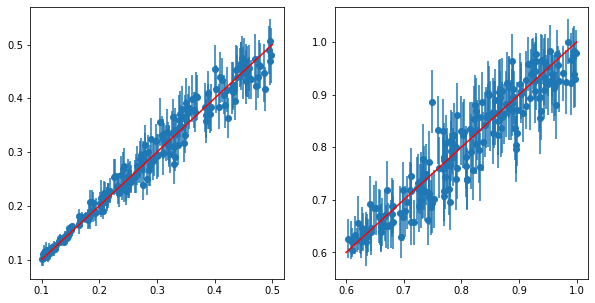

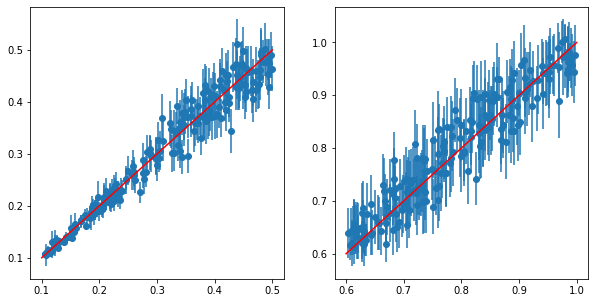

In [5]:
vib=vib1
vib.eval()
val_indices = np.array(val_indices)
x_tng, y_tng = X[val_indices[val_indices<1000]], y[val_indices[val_indices<1000],:2]
x_sim, y_sim = X[val_indices[val_indices>1000]], y[val_indices[val_indices>1000],:2]

y_tng_pred,y_sigma = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()
y_sigma    = np.abs(y_sigma.cpu().detach().numpy())

rel1 = (y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = (y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = np.abs(y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_tng[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_tng[:,1],y_tng_pred[:,1]))



fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0])
plt.errorbar(y_tng[:,0],y_tng_pred[:,0],2*y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1])
plt.errorbar(y_tng[:,1],y_tng_pred[:,1],2*y_sigma[:,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")





y_sim_pred,y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_sim_pred = y_sim_pred.cpu().detach().numpy()
y_sigma    = np.abs(y_sigma.cpu().detach().numpy())

rel1 = (y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_sim_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_sim_pred[:,1]))

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_sim_pred[:,0])
plt.errorbar(y_sim[:,0],y_sim_pred[:,0],2*y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_sim_pred[:,1])
plt.errorbar(y_sim[:,1],y_sim_pred[:,1],2*y_sigma[:,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")

### Bias Test

tensor(-0.0164)
tensor(0.0097)
tensor(0.0497) 0.9702301536315476
tensor(0.0363) 0.8781866583967118
tensor(0.0118)
tensor(-0.0106)
tensor(0.0542) 0.9613024841112611
tensor(0.0389) 0.8906445783402653


/tmp/ipykernel_993717/3986192253.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred,y_sigma = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
/tmp/ipykernel_993717/3986192253.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_sim_pred,y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


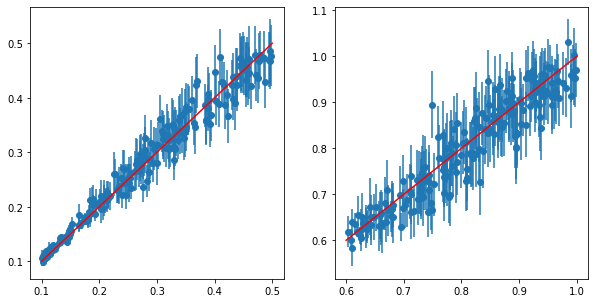

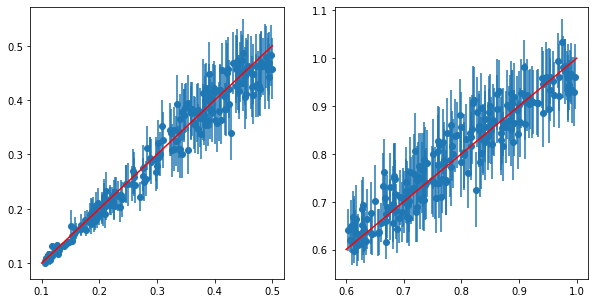

In [75]:
vib=vib1
vib.eval()
val_indices = np.array(val_indices)
x_tng, y_tng = X[val_indices[val_indices<1000]], y[val_indices[val_indices<1000],:2]
x_sim, y_sim = X[val_indices[val_indices>1000]], y[val_indices[val_indices>1000],:2]

y_tng_pred,y_sigma = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()
y_sigma    = np.abs(y_sigma.cpu().detach().numpy())

rel1 = (y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = (y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = np.abs(y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_tng[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_tng[:,1],y_tng_pred[:,1]))



fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0])
plt.errorbar(y_tng[:,0],y_tng_pred[:,0],2*y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1])
plt.errorbar(y_tng[:,1],y_tng_pred[:,1],2*y_sigma[:,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")





y_sim_pred,y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_sim_pred = y_sim_pred.cpu().detach().numpy()
y_sigma    = np.abs(y_sigma.cpu().detach().numpy())

rel1 = (y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_sim_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_sim_pred[:,1]))

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_sim_pred[:,0])
plt.errorbar(y_sim[:,0],y_sim_pred[:,0],2*y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_sim_pred[:,1])
plt.errorbar(y_sim[:,1],y_sim_pred[:,1],2*y_sigma[:,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")

# Captum

In [76]:
import captum
reload(captum)
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [77]:
ig = captum.attr.IntegratedGradients(vib1.cuda())

test_input_tensor = X[val_indices].cuda()
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=0, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

visualize_importances(np.mean(attr, axis=0))
#plt.yscale("symlog")

AttributeError: 'tuple' object has no attribute 'shape'

In [12]:
mean_attr = np.abs(np.mean(attr, axis=0))
np.where(mean_attr>0.1)[0]

array([504, 506, 509, 510, 512])

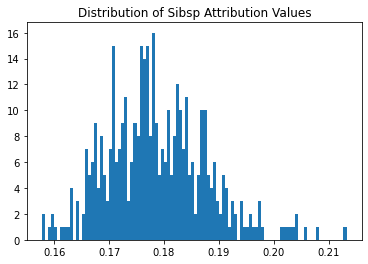

In [30]:
plt.hist(attr[:,510], 100);
plt.title("Distribution of Sibsp Attribution Values");

Average Feature Importances


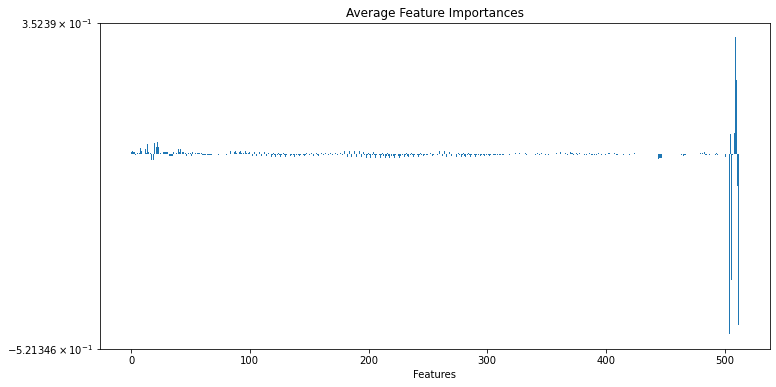

In [7]:
# Helper method to print importances and visualize distribution
def visualize_importances(importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    #for i in range(len(feature_names)):
    #    print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(importances)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        #plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(np.mean(attr, axis=0))
plt.yscale("symlog")

## Important coefficient only

In [15]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

index = [504, 506, 509, 510, 512]
# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(np.absolute(coef)[:,index],dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

# Hyperparameters
beta   = 1e-3
input_shape  = X.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib1 = newVIB(input_shape, output_shape,z_dim)
total_loss, accuracy = new_train_vib(vib1, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:463: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 6.4268... Accuracy: 0.0027... Test Om: 0.348 sig: 0.090
Epoch: 200/3000... Loss: 6.4241... Accuracy: 0.0021... Test Om: 0.169 sig: 0.092
Epoch: 300/3000... Loss: 6.4226... Accuracy: 0.0018... Test Om: 0.135 sig: 0.093
Epoch: 400/3000... Loss: 6.4226... Accuracy: 0.0018... Test Om: 0.114 sig: 0.087
Epoch: 500/3000... Loss: 6.4222... Accuracy: 0.0017... Test Om: 0.112 sig: 0.087
Epoch: 600/3000... Loss: 6.4222... Accuracy: 0.0017... Test Om: 0.112 sig: 0.086
Epoch: 700/3000... Loss: 6.4220... Accuracy: 0.0016... Test Om: 0.103 sig: 0.086
Epoch: 800/3000... Loss: 6.4219... Accuracy: 0.0016... Test Om: 0.109 sig: 0.081
Epoch: 900/3000... Loss: 6.4222... Accuracy: 0.0018... Test Om: 0.135 sig: 0.082
Epoch: 1000/3000... Loss: 6.4216... Accuracy: 0.0016... Test Om: 0.108 sig: 0.081
Epoch: 1100/3000... Loss: 6.4216... Accuracy: 0.0016... Test Om: 0.109 sig: 0.081
Epoch: 1200/3000... Loss: 6.4215... Accuracy: 0.0016... Test Om: 0.111 sig: 0.080
Epoch: 1300/3000... Loss:

Average Feature Importances


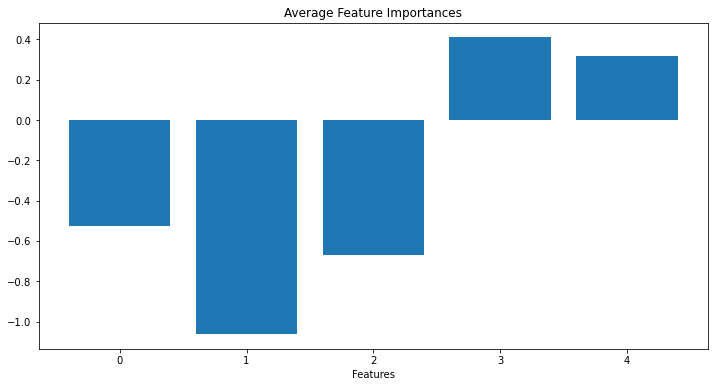

In [16]:
ig = captum.attr.IntegratedGradients(vib1.cuda())

test_input_tensor = X[val_indices].cuda()
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=0, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

visualize_importances(np.mean(attr, axis=0))
#plt.yscale("symlog")

In [18]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

index_        = [504, 506, 509, 510, 512]
index         = np.array([True]*513)
index[index_] = False
# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(np.absolute(coef)[:,index],dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

# Hyperparameters
beta   = 1e-3
input_shape  = X.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib1 = newVIB(input_shape, output_shape,z_dim)
total_loss, accuracy = new_train_vib(vib1, train_loader, device, epochs,batch_size,test_dataset)
#del vib

Epoch: 100/3000... Loss: 6.4208... Accuracy: 0.0016... Test Om: 0.102 sig: 0.084
Epoch: 200/3000... Loss: 6.4193... Accuracy: 0.0013... Test Om: 0.080 sig: 0.056
Epoch: 300/3000... Loss: 6.4184... Accuracy: 0.0012... Test Om: 0.077 sig: 0.052
Epoch: 400/3000... Loss: 6.4180... Accuracy: 0.0012... Test Om: 0.121 sig: 0.050
Epoch: 500/3000... Loss: 6.4177... Accuracy: 0.0010... Test Om: 0.091 sig: 0.054
Epoch: 600/3000... Loss: 6.4182... Accuracy: 0.0011... Test Om: 0.095 sig: 0.054
Epoch: 700/3000... Loss: 6.4170... Accuracy: 0.0009... Test Om: 0.085 sig: 0.043
Epoch: 800/3000... Loss: 6.4167... Accuracy: 0.0009... Test Om: 0.073 sig: 0.042
Epoch: 900/3000... Loss: 6.4165... Accuracy: 0.0008... Test Om: 0.079 sig: 0.040
Epoch: 1000/3000... Loss: 6.4165... Accuracy: 0.0008... Test Om: 0.076 sig: 0.040
Epoch: 1100/3000... Loss: 6.4164... Accuracy: 0.0008... Test Om: 0.083 sig: 0.041
Epoch: 1200/3000... Loss: 6.4163... Accuracy: 0.0008... Test Om: 0.075 sig: 0.042
Epoch: 1300/3000... Loss:

Average Feature Importances


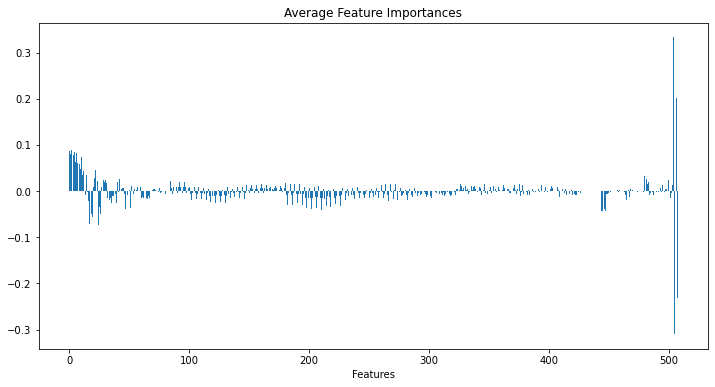

In [19]:
ig = captum.attr.IntegratedGradients(vib1.cuda())

test_input_tensor = X[val_indices].cuda()
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=0, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

visualize_importances(np.mean(attr, axis=0))
#plt.yscale("symlog")

In [21]:
mean_attr = np.abs(np.mean(attr, axis=0))
np.where(mean_attr>0.1)[0]

array([504, 505, 506, 507])

## Plot

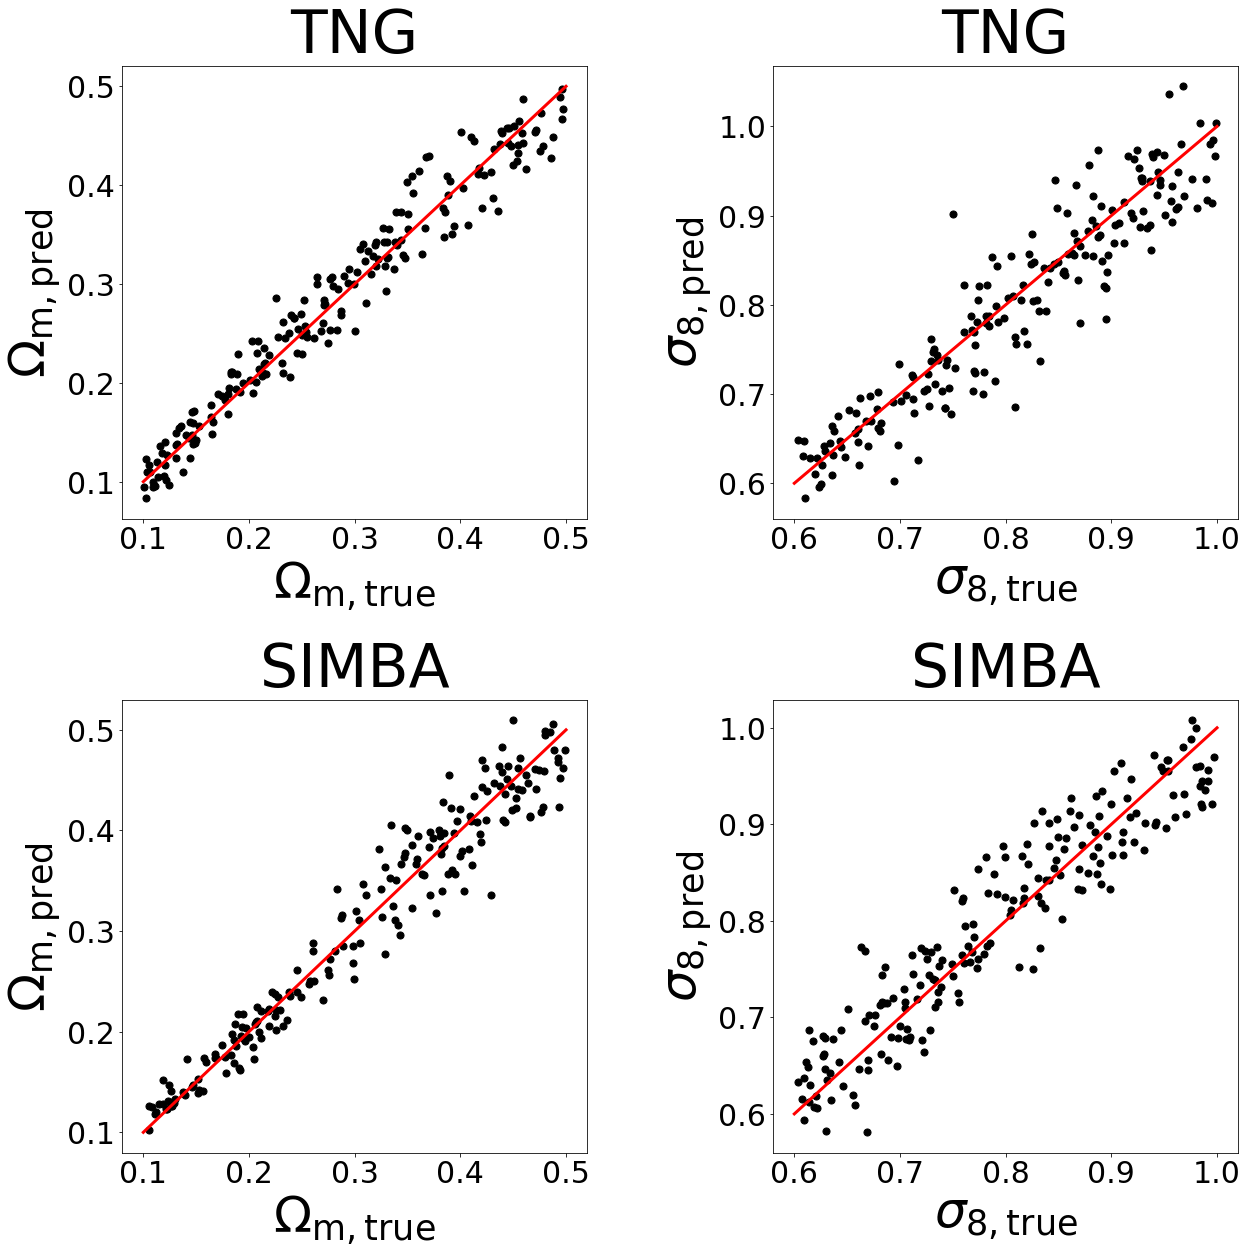

In [98]:
plt.rcParams['font.size'] = '50'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'sans-serif'
plt.rcParams['xtick.labelsize'] = '30'
plt.rcParams['ytick.labelsize'] = '30'

fig = plt.figure(figsize=(20,20))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)

fig.add_subplot(2,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0],s=50,c='k')
plt.plot(ideal1,ideal1,"r",lw=3)
plt.xlabel("$\Omega_\mathrm{m, true}$")
plt.ylabel("$\Omega_\mathrm{m, pred}$")
plt.title('TNG')
fig.add_subplot(2,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1],s=50,c='k')
plt.plot(ideal2,ideal2,"r",lw=3)
plt.xlabel("$\sigma_\mathrm{8, true}$")
plt.ylabel("$\sigma_\mathrm{8, pred}$")
plt.title('TNG')

fig.add_subplot(2,2,3)
plt.scatter(y_sim[:,0],y_sim_pred[:,0],s=50,c='k')
plt.plot(ideal1,ideal1,"r",lw=3)
plt.xlabel("$\Omega_\mathrm{m, true}$")
plt.ylabel("$\Omega_\mathrm{m, pred}$")
plt.title('SIMBA')
fig.add_subplot(2,2,4)
plt.scatter(y_sim[:,1],y_sim_pred[:,1],s=50,c='k')
plt.plot(ideal2,ideal2,"r",lw=3)
plt.xlabel("$\sigma_\mathrm{8, true}$")
plt.ylabel("$\sigma_\mathrm{8, pred}$")
plt.title('SIMBA')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig("TNG_SIMBA_VIB.png", bbox_inches="tight", dpi=300)

## Without normalization

### Data load

In [8]:
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_IllustrisTNG_for_vib_total.npy")
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_SIMBA_for_vib_total.npy")
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
print(coef.shape, params.shape)

/tmp/ipykernel_821409/1726218710.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(2000, 513) (2000, 2)


/tmp/ipykernel_821409/1726218710.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


### Normalizations & Dataset for training

In [9]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(coef,dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

### Training VIB

In [14]:
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 50
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/tmp/ipykernel_821409/2107878760.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 1.6101... Accuracy: 0.0019... Test Om: 0.143 sig: 0.072


KeyboardInterrupt: 

tensor(0.0737)
tensor(0.0420)


/tmp/ipykernel_821409/1209562079.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))


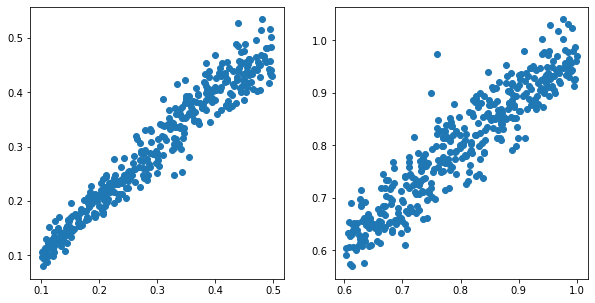

In [11]:
vib.eval()
x_tng, y_tng = X[val_indices[val_indices<1000]], y[val_indices[val_indices<1000]]
x_sim, y_sim = X[val_indices[val_indices>1000]], y[val_indices[val_indices>1000]]

y_tng_pred, _, _ = vib(torch.tensor(X,dtype=torch.float).to(device))
y_tng_pred = y_pred.cpu().detach().numpy()

rel1 = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
rel2 = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean())
print(rel2.mean())
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])

# TNG -> SIMBA

### Normalizations & Dataset for training

In [12]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(gparams,dtype=torch.float)
X = torch.tensor(np.absolute(gcoef_avg),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

### Training VIB

In [13]:
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


vib = newVIB(input_shape, output_shape,z_dim)
total_loss, accuracy = new_train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

Epoch: 100/3000... Loss: 6.4269... Accuracy: 0.0033... Test Om: 0.267 sig: 0.072
Epoch: 200/3000... Loss: 6.4199... Accuracy: 0.0016... Test Om: 0.110 sig: 0.061
Epoch: 300/3000... Loss: 6.4194... Accuracy: 0.0014... Test Om: 0.101 sig: 0.057
Epoch: 400/3000... Loss: 6.4185... Accuracy: 0.0013... Test Om: 0.113 sig: 0.053
Epoch: 500/3000... Loss: 6.4182... Accuracy: 0.0012... Test Om: 0.091 sig: 0.060
Epoch: 600/3000... Loss: 6.4182... Accuracy: 0.0012... Test Om: 0.093 sig: 0.052
Epoch: 700/3000... Loss: 6.4180... Accuracy: 0.0011... Test Om: 0.083 sig: 0.052
Epoch: 800/3000... Loss: 6.4181... Accuracy: 0.0011... Test Om: 0.074 sig: 0.049
Epoch: 900/3000... Loss: 6.4176... Accuracy: 0.0010... Test Om: 0.074 sig: 0.048
Epoch: 1000/3000... Loss: 6.4175... Accuracy: 0.0010... Test Om: 0.077 sig: 0.046
Epoch: 1100/3000... Loss: 6.4171... Accuracy: 0.0009... Test Om: 0.074 sig: 0.045
Epoch: 1200/3000... Loss: 6.4171... Accuracy: 0.0009... Test Om: 0.069 sig: 0.045
Epoch: 1300/3000... Loss:

Average Feature Importances


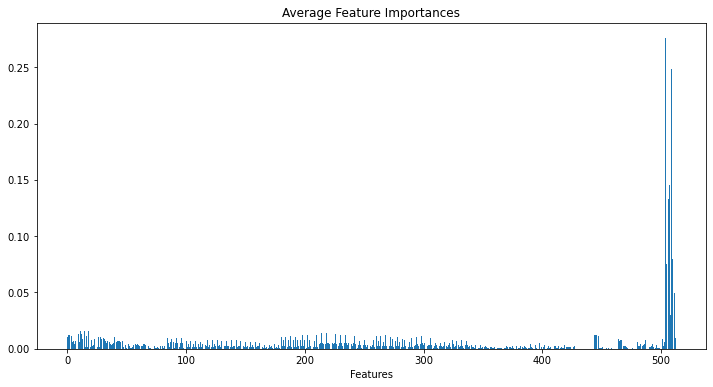

In [17]:
ig = captum.attr.IntegratedGradients(vib.cuda())

test_input_tensor = X[val_indices].cuda()
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=0, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

visualize_importances(np.abs(np.mean(attr, axis=0)))
#plt.yscale("log")

tensor(-0.0110) 0.9502791895106261
tensor(0.0026) 0.8653449057331569
tensor(0.0637) 0.9502791895106261
tensor(0.0425) 0.8653449057331569


/tmp/ipykernel_31465/1236285189.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))


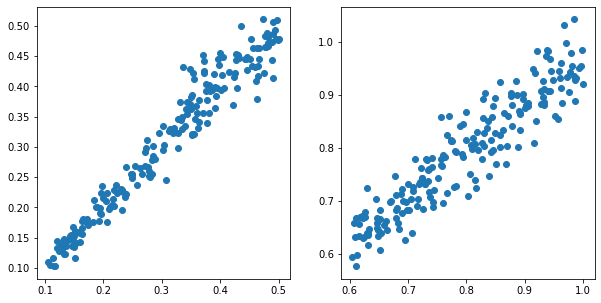

In [29]:
vib.eval()
X, y =test_dataset.tensors
y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel1 = (y[:,0]-y_pred[:,0])/y[:,0]
rel2 = (y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y[:,1],y_pred[:,1]))


rel1 = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
rel2 = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y[:,1],y_pred[:,1]))


fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])

tensor(-0.0692)
tensor(-0.0422)
tensor(0.1222) 0.7563175094550442
tensor(0.0817) 0.4820836315172947


/tmp/ipykernel_163796/230175210.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


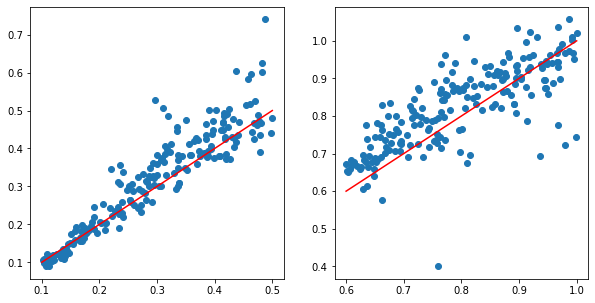

In [6]:
vib.eval()
val_indices = np.array(val_indices)

# Creating data indices for training and validation splits:
y_sim = torch.tensor(rparams[:200],dtype=torch.float)
x_sim = torch.tensor(np.absolute(rcoef_avg[:200]),dtype=torch.float)


y_tng_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()


rel1 = (y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_tng_pred[:,1]))


fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_tng_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_tng_pred[:,1])
plt.plot(ideal2,ideal2,"r")


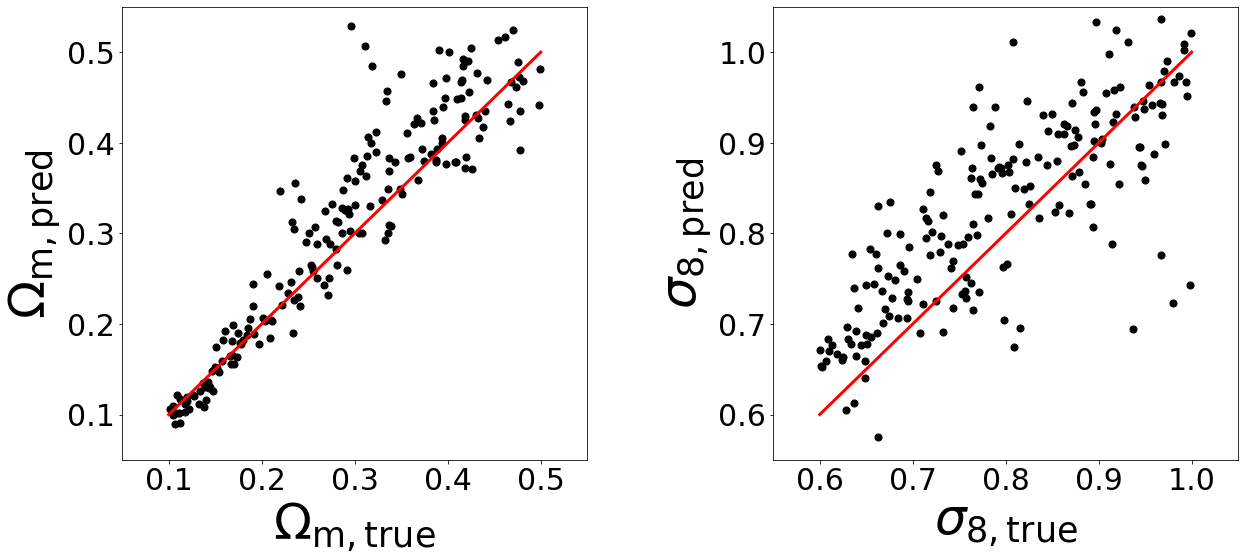

In [13]:
plt.rcParams['font.size'] = '50'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'sans-serif'
plt.rcParams['xtick.labelsize'] = '30'
plt.rcParams['ytick.labelsize'] = '30'

fig = plt.figure(figsize=(20,20))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)


fig.add_subplot(2,2,1)
plt.scatter(y_sim[:,0],y_tng_pred[:,0],s=50,c='k')
plt.plot(ideal1,ideal1,"r",lw=3)
plt.xlabel("$\Omega_\mathrm{m, true}$")
plt.ylabel("$\Omega_\mathrm{m, pred}$")
plt.xlim(0.05,0.55)
plt.ylim(0.05,0.55)
#plt.title('SIMBA')
fig.add_subplot(2,2,2)
plt.scatter(y_sim[:,1],y_tng_pred[:,1],s=50,c='k')
plt.plot(ideal2,ideal2,"r",lw=3)
plt.xlabel("$\sigma_\mathrm{8, true}$")
plt.ylabel("$\sigma_\mathrm{8, pred}$")
plt.xlim(0.55,1.05)
plt.ylim(0.55,1.05)
#plt.title('SIMBA')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig("TNG_to_SIMBA_VIB.png", bbox_inches="tight", dpi=300)

## SIMBA -> TNG

### Normalizations & Dataset for training

In [14]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(rparams,dtype=torch.float)
X = torch.tensor(np.absolute(rcoef_avg),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

### Training VIB

In [15]:
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 6.4235... Accuracy: 0.0022... Test Om: 0.221 sig: 0.093
Epoch: 200/3000... Loss: 6.4204... Accuracy: 0.0017... Test Om: 0.149 sig: 0.075
Epoch: 300/3000... Loss: 6.4201... Accuracy: 0.0015... Test Om: 0.149 sig: 0.067
Epoch: 400/3000... Loss: 6.4186... Accuracy: 0.0012... Test Om: 0.123 sig: 0.058
Epoch: 500/3000... Loss: 6.4183... Accuracy: 0.0012... Test Om: 0.126 sig: 0.059
Epoch: 600/3000... Loss: 6.4183... Accuracy: 0.0011... Test Om: 0.099 sig: 0.057
Epoch: 700/3000... Loss: 6.4177... Accuracy: 0.0010... Test Om: 0.098 sig: 0.053
Epoch: 800/3000... Loss: 6.4175... Accuracy: 0.0010... Test Om: 0.092 sig: 0.052
Epoch: 900/3000... Loss: 6.4175... Accuracy: 0.0010... Test Om: 0.089 sig: 0.051
Epoch: 1000/3000... Loss: 6.4175... Accuracy: 0.0010... Test Om: 0.093 sig: 0.052
Epoch: 1100/3000... Loss: 6.4172... Accuracy: 0.0009... Test Om: 0.088 sig: 0.050
Epoch: 1200/3000... Loss: 6.4172... Accuracy: 0.0010... Test Om: 0.084 sig: 0.050
Epoch: 1300/3000... Loss:

tensor(-0.0092) 0.9170424180702671
tensor(-0.0056) 0.8095287370625928
tensor(0.0838) 0.9170424180702671
tensor(0.0512) 0.8095287370625928


/tmp/ipykernel_31465/1843891868.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))


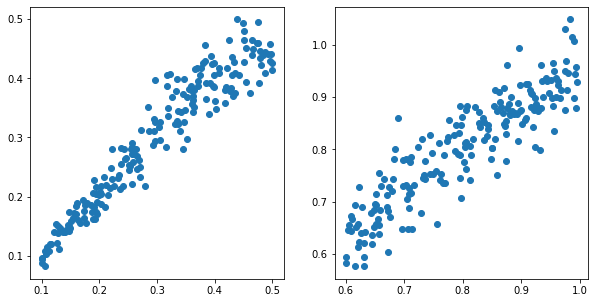

In [36]:
vib.eval()
X, y =test_dataset.tensors
y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel1 = (y[:,0]-y_pred[:,0])/y[:,0]
rel2 = (y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y[:,1],y_pred[:,1]))

rel1 = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
rel2 = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y[:,1],y_pred[:,1]))


fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])

tensor(-0.0411)
tensor(0.0745)
tensor(0.0940) 0.9254328251118794
tensor(0.0815) 0.4743924518845417


/tmp/ipykernel_163796/4105641109.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


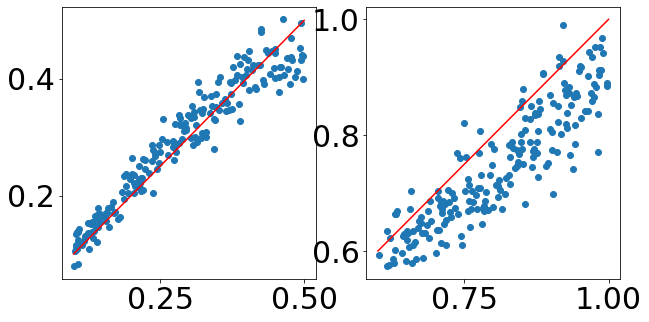

In [16]:
vib.eval()
val_indices = np.array(val_indices)

# Creating data indices for training and validation splits:
y_sim = torch.tensor(gparams[:200],dtype=torch.float)
x_sim = torch.tensor(np.absolute(gcoef_avg[:200]),dtype=torch.float)


y_tng_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()


rel1 = (y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())



rel1 = np.abs(y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_tng_pred[:,1]))

fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_tng_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_tng_pred[:,1])
plt.plot(ideal2,ideal2,"r")


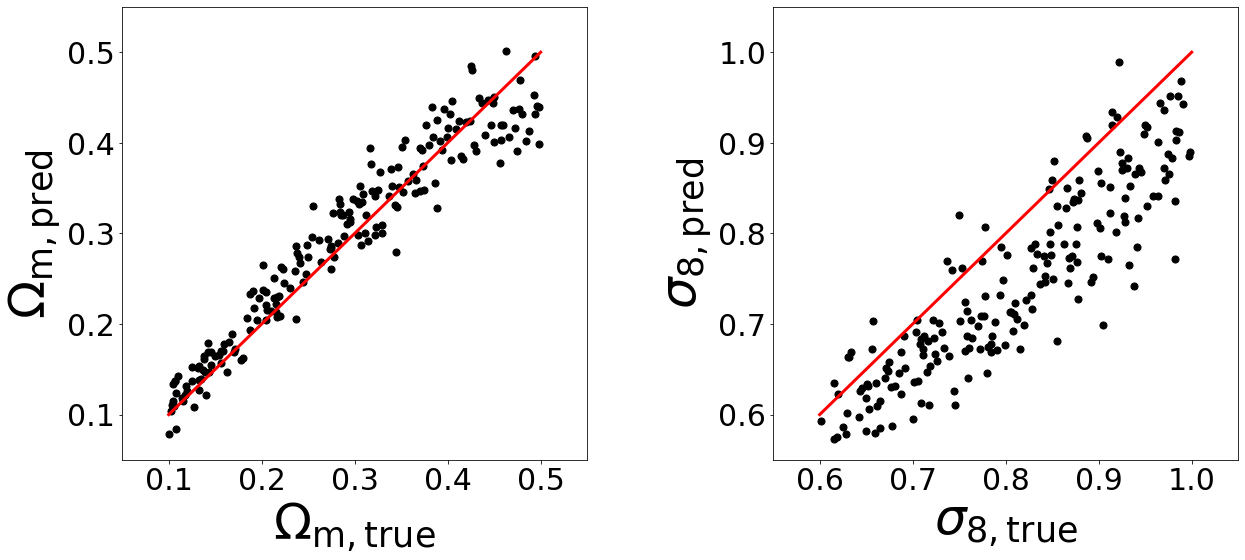

In [17]:
plt.rcParams['font.size'] = '50'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'sans-serif'
plt.rcParams['xtick.labelsize'] = '30'
plt.rcParams['ytick.labelsize'] = '30'

fig = plt.figure(figsize=(20,20))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)


fig.add_subplot(2,2,1)
plt.scatter(y_sim[:,0],y_tng_pred[:,0],s=50,c='k')
plt.plot(ideal1,ideal1,"r",lw=3)
plt.xlabel("$\Omega_\mathrm{m, true}$")
plt.ylabel("$\Omega_\mathrm{m, pred}$")
plt.xlim(0.05,0.55)
plt.ylim(0.05,0.55)
#plt.title('SIMBA')
fig.add_subplot(2,2,2)
plt.scatter(y_sim[:,1],y_tng_pred[:,1],s=50,c='k')
plt.plot(ideal2,ideal2,"r",lw=3)
plt.xlabel("$\sigma_\mathrm{8, true}$")
plt.ylabel("$\sigma_\mathrm{8, pred}$")
plt.xlim(0.55,1.05)
plt.ylim(0.55,1.05)
#plt.title('SIMBA')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig("SIMBA_to_TNG_VIB.png", bbox_inches="tight", dpi=300)